<a href="https://colab.research.google.com/github/SaraTouzani/HCAN_/blob/master/HCAN_HCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path_ = '/content/gdrive/My Drive/Projet_representation_learning/'
import pandas
import io
from os import path
import string
import numpy as np
import re
import nltk
from keras.utils import to_categorical

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.preprocessing.sequence import pad_sequences
#nltk.download('punkt')
import tensorflow as tf
from tensorflow import math
from tensorflow import keras
import  tensorflow.keras.backend as K
import keras.layers

from keras.layers import multiply
from keras_layer_normalization import LayerNormalization
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Activation, Dropout , concatenate
from keras.constraints import max_norm
from keras.initializers import glorot_normal
from keras.utils import plot_model
from keras.layers import Flatten
from scipy.special import softmax
from keras import backend as K
from keras.layers import Dropout
import tensorflow as tf
import numpy as np
from keras.layers import LSTM
from keras.layers import Bidirectional


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Préparation des Données

In [0]:
corpus = pandas.read_excel(path_+"corpus.xlsx")
texts = corpus["Campaign Text"]
labels = corpus["LEAD ARCHETYPE"]
corpus.shape, texts

((212, 3), 0      SPONSOR CONTENT BY Prudential\nA millennial’s ...
 1      PASSAGE TO INSPIRATION\nPAID PROGRAM\nDESIGN T...
 2      SPECIAL ADVERTISING FEATURE\nSponsored by HP\n...
 3      Bring the wellness trend to your bedroom with ...
 4      IN PARTNERSHIP WITH NETFLIX\n5 Hilariously Bad...
                              ...                        
 207    PAID PROGRAM\nLOGISTICS REPORT\nSuccess Withou...
 208    EXPERIENTIAL\nJOURNEYS\nA JOURNEY INTO INDIA, ...
 209    Mr. Mateusz Morawiecki - the new Prime Ministe...
 210    PAID FOR AND POSTED BY SOTHEBY’S INTERNATIONAL...
 211    Inside The Egyptian Community Thriving In Mode...
 Name: Campaign Text, Length: 212, dtype: object)

In [0]:
train_texts = texts[:160]
test_texts = texts[160:]
train_labels = labels[:160]
test_labels = labels[160:]

In [0]:
text=''
for elm in train_texts:
    text+=elm

In [0]:
vocabulary=set()
clean_unicode = {
    'http[\s|:|/|s]*[\w|.|/|\d]*':"",
    "[^\x01-\x7F]":" ",
    "HJuly":"July",
    "'s":" ",
#    '\w+s':" ",
    '[ \s\t\n\r\f\v]+':" ",
    "\W":" ",
    '[ \s\t\n\r\f\v]+':" "
}

def process_txts(texts, update_vocabulary):
    articles = []

    for article in texts:
      parsed = process_article(article, update_vocabulary)
      articles.append(parsed)
    return articles

def process_article(article, update_vocabulary):

    txt_propre = article
    for c in clean_unicode:
        txt_propre = re.sub(c, clean_unicode[c], txt_propre.lower())
        
    tokens_clean=txt_propre.split(' ')
    tokens_clean=[token for token in tokens_clean if token!=""]

    if update_vocabulary:
        for token in set(tokens_clean):
            vocabulary.add(token)
    return tokens_clean

train_data = process_txts(train_texts, update_vocabulary=True)
test_data=process_txts(test_texts,update_vocabulary=True)

In [0]:
len(vocabulary)

18260

### Chargement des représentations des mots

In [0]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array([float(tokens[i]) for i in range(1, 301)])
    return data

In [0]:
if not path.exists("wiki-news-300d-1M.vec"):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
    !unzip wiki-news-300d-1M.vec.zip


--2020-02-02 15:31:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  13.0MB/s    in 51s     

2020-02-02 15:32:50 (12.7 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [0]:
all_vectors = load_vectors("wiki-news-300d-1M.vec")

In [0]:
len(all_vectors)

999994

In [0]:
unknown_words = set([word for word in vocabulary if word not in all_vectors])
vocabulary = list(vocabulary - unknown_words)
word_map = {}
word_vectors = np.zeros((len(vocabulary) + 2, 300))
for i in range(len(vocabulary)):
    word_map[vocabulary[i]] = i
    word_vectors[i] = all_vectors[vocabulary[i]]
word_vectors[len(vocabulary)] = np.random.uniform(low=-0.1, high=0.1, size=300)
word_vectors[len(vocabulary) + 1] = np.random.uniform(low=-0.1, high=0.1, size=300)
default_index = len(vocabulary)
def get_index(word):
    return word_map.get(word, default_index)

In [0]:
def get_index(word):
    return word_map.get(word, default_index)

In [0]:
len(unknown_words)

1505

In [0]:
len(vocabulary)

16755

In [0]:
get_index('bottle')

10302

In [0]:
def format_sentences(article,max_length=None,max_sentence = None):
    if max_length == None:
        max_length = max([len(sentence) for sentence in article])
    tokens = nltk.sent_tokenize(article)
    nb_sentences = len(tokens)
    doc = np.zeros((nb_sentences,max_length))
    t=0
    for i in range(nb_sentences):
        tmp=tokens[i]
        tmp2 = nltk.wordpunct_tokenize(tmp)
        sentences = []
        for word in tmp2:
            sentences.append(get_index(word))
          
            sequences = pad_sequences([sentences], 
                              maxlen=max_length, 
                              dtype='int32', 
                              padding='post', 
                              truncating='pre',
                              value=len(vocabulary)+1) # id pour les tokens "hors phrase"
          
        doc[i,:] = sequences[0]
      
    if max_sentence == None:
        return doc
    
    
    return doc[:max_sentence,:]

In [0]:
format_sentences(train_texts[46],max_length=15,max_sentence=14).shape

(14, 15)

In [0]:
len(train_texts)
data = np.zeros((len(train_texts), 11, 15))
for i in range(len(train_texts)):
    data[i,:,:] = format_sentences(train_texts[i],max_length=15,max_sentence=11)
    #print(format_sentences(train_texts[i],max_length=15,max_sentence=11).shape,data[i,:,:].shape, i)


In [0]:
y = np.arange(160)
for i in range(len(y)):
    if train_labels[i] == 'Entertaining':
        y[i] = 0
    elif train_labels[i] == 'Informative':
        y[i] = 1
    elif train_labels[i] == 'Inspirational':
        y[i] = 2
    else:
        y[i] = 3

In [0]:
y

array([3, 2, 1, 3, 0, 0, 2, 2, 3, 1, 2, 1, 2, 3, 2, 1, 3, 2, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 3, 0,
       3, 2, 3, 3, 3, 1, 1, 2, 1, 1, 1, 3, 1, 3, 0, 2, 0, 0, 0, 0, 1, 3,
       1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 0, 3, 0, 2, 1, 1, 1, 1, 0, 1, 3, 1,
       1, 3, 1, 1, 2, 2, 3, 3, 0, 2, 2, 2, 2, 1, 3, 0, 3, 2, 3, 1, 3, 1,
       3, 1, 0, 1, 1, 0, 0, 1, 1, 3, 0, 1, 2, 1, 3, 3, 2, 3, 1, 1, 3, 1,
       1, 1, 0, 2, 1, 3, 1, 0, 2, 2, 0, 2, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1,
       3, 1, 3, 0, 2, 1])

In [0]:
train_labels_categorical = to_categorical(y,num_classes=4)

In [0]:
train_X, test_X, train_y, test_y = train_test_split(data, train_labels_categorical, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=123)

In [0]:
train_y[0].reshape(1,4)

array([[0., 0., 0., 1.]], dtype=float32)

In [0]:
train_X.shape

(112, 11, 15)

In [0]:
sess = tf.Session()

In [0]:
inputs = K.placeholder(ndim=3)
I=K.constant(np.arange(9).reshape(3,3))
H=K.constant(np.arange(1,10).reshape(3,3))
H

<tf.Tensor 'Const_1:0' shape=(3, 3) dtype=float32>

In [0]:
K.eval(K.dot(I, K.transpose(H)))

array([[  8.,  17.,  26.],
       [ 26.,  62.,  98.],
       [ 44., 107., 170.]], dtype=float32)

In [0]:
(softmax(I.eval(session=sess)))

array([[2.1207906e-04, 5.7649065e-04, 1.5670641e-03],
       [4.2597218e-03, 1.1579124e-02, 3.1475324e-02],
       [8.5558802e-02, 2.3257293e-01, 6.3219881e-01]], dtype=float32)

In [0]:
def softmax(x):
    return K.exp(x)/K.sum(K.exp(x))

In [1]:
Attention=K.dot(softmax(K.dot(Q,K.transpose(Key)/np.sqrt(300))),V)

In [0]:
input_words

<tf.Tensor 'words_10:0' shape=(?, 15) dtype=float32>

In [0]:
W=word_vectors
max_length=15
max_sentences = 11
n_filters=150
filter_sizes=3
# Configuration de l'entrée
input_words = Input(shape=(max_length,), name="words")
# Configuration de la couche de représentation des mots - statique
words_embedding = Embedding(input_dim=len(vocabulary)+2, # taille du vocabulaire
                            output_dim=300, # dimension de l'espace d'embedding des mots
                            input_length=max_length, # longeur maximale des textes
                            weights=[W], 
                            name="words_embedding")(input_words)
                     

#words_embedding_splited = tf.split(words_embedding,2, -1)
words_embedding_splited=Lambda(lambda x: tf.split(x, 2, -1))(words_embedding)


In [0]:
words_embedding_splited[0]

<tf.Tensor 'lambda_145/split:0' shape=(?, 15, 150) dtype=float32>

### Definition du modèle du Réseau HCAN (Hierarchical Convolutional Attention Networks)

In [0]:
Q1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q1")(words_embedding_splited[0])
Key1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key1")(words_embedding_splited[0])
V1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V1")(words_embedding_splited[0])


#Multii = tf.matmul(Q1, Key1,transpose_b=True,name="Multi")
#slice0 = Lambda(lambda x: x)(Q1)
#slice1 = Lambda(lambda x: x)(Key1)
Multi = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True,name="Produit_Q_K"))([Q1, Key1])
qk=Lambda(lambda x: tf.math.divide(x, np.sqrt(150)))(Multi)
soft=Lambda(lambda x: tf.nn.softmax(x,name="softmax"))(qk)
head1 = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=False,name="head1"))([soft, V1])

#head2 = tf.matmul(soft, V2)
#K=tf.matmul(Q1, Key1, transpose_b=True)

merge_convolution = K

h1 = Dense(200,activation="tanh",name="h1")((head1))
h2 = Dense(4,activation="softmax",name="h2")(h1)

word_encoder = Model(inputs=input_words, outputs=h2)                            
soft = tf.nn.softmax(qk)
head1 = tf.matmul(soft, V1)

Q2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q2")(words_embedding_splited[1])
Key2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key2")(words_embedding_splited[1])
V2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V2")(words_embedding_splited[1])

K=tf.matmul(Q2, Key2, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head2 = tf.matmul(soft, V2)

Multihead_elu = concatenate([head1,head2], name="Multihead_Self_Attention_elu", axis=-1)
Multihead_elu



<tf.Tensor 'Multihead_Self_Attention_elu_41/concat:0' shape=(?, 13, 300) dtype=float32>

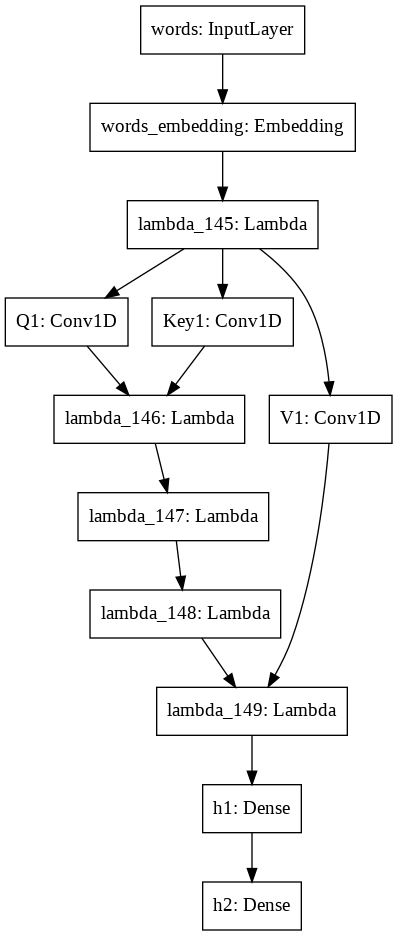

In [0]:
plot_model(word_encoder)

In [0]:
K=tf.matmul(Q1, Key1, transpose_b=True)
K,masked

(<tf.Tensor 'MatMul_496:0' shape=(?, 13, 13) dtype=float32>,
 <tf.Tensor 'lambda_12/MatMul:0' shape=(?, 13, 13) dtype=float32>)

In [3]:
h3 = Dense(20, activation="tanh", name = "h3")(Multihead_elu)
h4 = Dense(11,activation="softmax",name="h4")(h3)
flatten_dim = Flatten()(h4)
    
preds = Dense(4, activation='softmax')(Q1)
Model(input = input_words, outputs = preds)

In [0]:
Q11 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Q11")(words_embedding_splited[0])
Key11 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Key11")(words_embedding_splited[0])
V11 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V11")(words_embedding_splited[0])

K=tf.matmul(Q11, Key11, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head11 = tf.matmul(soft, V11)

Q22 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Q22")(words_embedding_splited[1])
Key22 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Key22")(words_embedding_splited[1])
V22 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V22")(words_embedding_splited[1])

K=tf.matmul(Q22, Key22, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head22 = tf.matmul(soft, V22)

Multihead_tanh = concatenate([head11,head22], name="Multihead_Self_Attention_tanh", axis=-1)
Multihead_tanh

Multi=tf.multiply(Multihead_tanh,Multihead_elu)
word_Norm=tf.keras.backend.l2_normalize(Multi) 

In [4]:
from sklearn.model_selection import train_test_split
#!pip install keras-layer-normalization

In [5]:

"""from tensorflow.keras import layers
class Linear(layers.Layer):

  def __init__(self, units=32, input_dim=32):
    super(Linear, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

x = tf.ones((1, 1))
linear_layer = Linear(150, 1)
T = linear_layer(x)"""
T= tf.Variable(tf.random.normal((1, 150)))

K = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="K" )(word_Norm)
V = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="V" )(word_Norm)

K,V                      
result=tf.matmul(T, K, transpose_b=True)
TK = tf.math.divide(result, np.sqrt(150))
soft = tf.nn.softmax(TK)
TargetAttention = tf.matmul(soft, V)


preds = Dense(4, activation='softmax')(TargetAttention)
model=Model(inputs=input_words,outputs=preds)

In [0]:
######### for sentences
input_sentences = Input(shape=(max_sentences, max_length), name = "sentences")


input_sentences_splited = tf.split(input_sentences,3, -1)


Q1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(input_sentences_splited[0])
Key1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(input_sentences_splited[0])
V1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(input_sentences_splited[0])

K=tf.matmul(Q1, Key1, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head1 = tf.matmul(soft, V1)

Q2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(input_sentences_splited[1])
Key2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(input_sentences_splited[1])
V2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(input_sentences_splited[1])

K=tf.matmul(Q2, Key2, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head2 = tf.matmul(soft, V2)

Q3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Q")(input_sentences_splited[2])
Key3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="Key")(input_sentences_splited[2])
V3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='elu',
                          name="V")(input_sentences_splited[2])

K=tf.matmul(Q3, Key3, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head3 = tf.matmul(soft, V3)

Multihead_elu = tf.concat([head1,head2,head3], name="Sentences_Multihead_Self_Attention_elu", axis=-1)
Multihead_elu


##
Q1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Q")(input_sentences_splited[0])
Key1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Key")(input_sentences_splited[0])
V1 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V")(input_sentences_splited[0])

K=tf.matmul(Q1, Key1, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head1 = tf.matmul(soft, V1)

Q2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Q")(input_sentences_splited[1])
Key2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Key")(input_sentences_splited[1])
V2 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V")(input_sentences_splited[1])

K=tf.matmul(Q2, Key2, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head2 = tf.matmul(soft, V2)

Q3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Q")(input_sentences_splited[2])
Key3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="Key")(input_sentences_splited[2])
V3 = Conv1D(n_filters, # nombre de filtres
                          kernel_size=3, # taille des filtres
                          padding="valid", 
                          activation='tanh',
                          name="V")(input_sentences_splited[2])

K=tf.matmul(Q3, Key3, transpose_b=True)
qk = tf.math.divide(K, np.sqrt(150))
soft = tf.nn.softmax(qk)
head3 = tf.matmul(soft, V3)

Multihead_tanh = tf.concat([head1,head2,head3], name="Sentences_Multihead_Self_Attention_tanh", axis=-1)
Multihead_tanh

MultiHeads=[]
Multi=tf.multiply(Multihead_tanh,Multihead_elu)
Sent_Norm=tf.keras.backend.l2_normalize(Multi) 

In [0]:
K = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="K" )(Sent_Norm)
V = Conv1D(n_filters,
                     kernel_size=3,
                      activation= "elu",
                      name="V" )(Sent_Norm)

K,V                      

(<tf.Tensor 'K_4/Elu:0' shape=(?, 7, 150) dtype=float32>,
 <tf.Tensor 'V_135/Elu:0' shape=(?, 7, 150) dtype=float32>)

In [0]:
from tensorflow.keras import layers
class Linear(layers.Layer):

  def __init__(self, units=32, input_dim=32):
    super(Linear, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

x = tf.ones((1, 1))
linear_layer = Linear(150, 1)
T = linear_layer(x)
T


<tf.Tensor 'linear_7/add:0' shape=(1, 150) dtype=float32>

In [6]:
result=tf.matmul(T, K, transpose_b=True)
TK = tf.math.divide(result, np.sqrt(150))
soft = tf.nn.softmax(TK)
TargetAttention = tf.matmul(soft, V)

preds = Dense(4, activation='softmax')(TargetAttention)
model=Model(inputs=input_words,outputs=preds)

### Definition du modèle du Réseau HCN (Hierarchical Convolutional  Networks)

In [0]:
def HCN(W,max_length=10,max_sentences = 15,n_filters=300,filter_sizes=3):
    # Configuration de l'entrée
    input_words = Input(shape=(max_length,), name="words")
    # Configuration de la couche de représentation des mots - statique
    words_embedding = Embedding(input_dim=len(vocabulary)+2, # taille du vocabulaire
                               output_dim=300, # dimension de l'espace d'embedding des mots
                               input_length=max_length, # longeur maximale des textes
                               weights=[W], 
                               name="words_embedding")(input_words)
    Q = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="Q")(words_embedding)
    Key = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="Key")(words_embedding)
    V = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="V")(words_embedding)

    merge_convolution = concatenate([Q,Key,V], name="concatenate_pooling")

    h1 = Dense(200,activation="tanh",name="h1")(merge_convolution)
    h2 = Dense(15,activation="softmax",name="h2")(h1)
   
    word_encoder = Model(inputs=input_words, outputs=h2)      

    input_sentences = Input(shape=(max_sentences, max_length), name = "sentences")
    
    Q1 = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="Q1")(input_sentences)
    Key1 = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="Key1")(input_sentences)
    V1 = Conv1D(n_filters, # nombre de filtres
                             kernel_size=3, # taille des filtres
                             padding="valid", 
                             activation='elu',
                             name="V1")(input_sentences)
    
    merge_convolution1 = concatenate([Q1,Key1,V1], name="concatenate_pooling1")

    h3 = Dense(20, activation="tanh", name = "h3")(merge_convolution1)
    h4 = Dense(11,activation="softmax",name="h4")(h3)
    flatten_dim = Flatten()(h4)
    
    preds = Dense(4, activation='softmax')(flatten_dim)
    return  Model(input = input_sentences, outputs = preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("se...)`


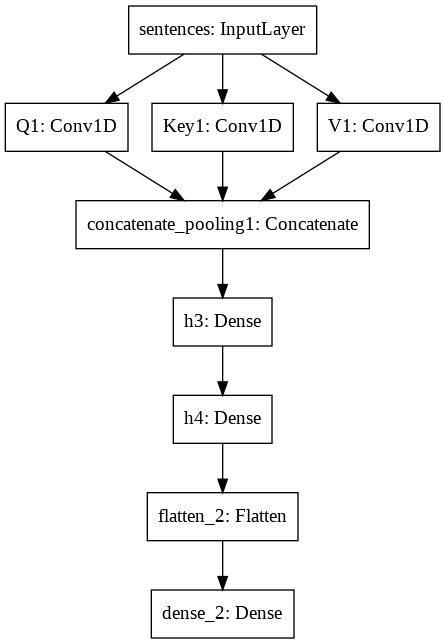

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialisation du modèle
model = HCN(word_vectors, 
                         max_length = 15,
                         max_sentences = 11,
                         n_filters=300,
                         filter_sizes=3)
plot_model(model)

In [0]:
model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentences (InputLayer)          (None, 11, 15)       0                                            
__________________________________________________________________________________________________
Q1 (Conv1D)                     (None, 9, 300)       13800       sentences[0][0]                  
__________________________________________________________________________________________________
Key1 (Conv1D)                   (None, 9, 300)       13800       sentences[0][0]                  
__________________________________________________________________________________________________
V1 (Conv1D)                     (None, 9, 300)       13800       sentences[0][0]                  
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 112 samples, validate on 48 samples
Epoch 1/50
112/112 [==============================] - 1s 9ms/step - loss: 1.3385 - acc: 0.3661 - val_loss: 1.3616 - val_acc: 0.3542
Epoch 2/50
112/112 [==============================] - 0s 2ms/step - loss: 1.3030 - acc: 0.4375 - val_loss: 1.3464 - val_acc: 0.3542
Epoch 3/50
112/112 [==============================] - 0s 2ms/step - loss: 1.2999 - acc: 0.4375 - val_loss: 1.3575 - val_acc: 0.3542
Epoch 4/50
112/112 [==============================] - 0s 2ms/step - loss: 1.3036 - acc: 0.4375 - val_loss: 1.3684 - val_acc: 0.3542
Epoch 5/50
112/112 [==============================] - 0s 1ms/step - loss: 1.3025 - acc: 0.4375 - val_loss: 1.3568 - val_acc: 0.3542
Epoch 6/50
112/112 [==============================] - 0s 1ms/step - loss: 1.3001 - acc: 0.4375 - val_loss: 1.3682 - val_acc: 0.3542
Epoch 7/50
112/112 [==============================] - 0s 2ms/step -

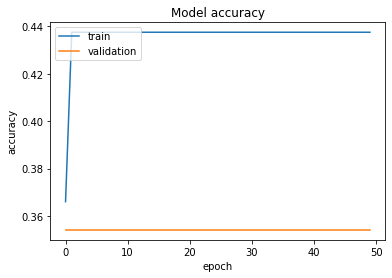

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Optimisation
log = model.fit(train_X,
                train_y,
                batch_size=2,
                epochs=50,
                validation_data=(test_X, 
                                 test_y))

# Visualisation des courbes d'apprentissage
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
train_input.shape,test_input.shape

((160, 1000), (52, 1000))